In [1]:
%matplotlib inline
from rrm_import_helper import *

In [2]:
ticker = "SPY"
item = dataio.DataItem(ticker)
data = item.raw_time_series_data

In [20]:
five_days_future = data.Close.copy()
five_days_future = five_days_future[five_days_future.notnull()].to_frame()
five_days_future.columns = ["day0"]

dd6 = core.rolling_drawdown(five_days_future["day0"], 6)
five_days_future["dd6"] = dd6

In [37]:
five_days_future["ret_minus5_now"] = five_days_future['day0'].pct_change(periods=5)
five_days_future["ret_vol"] = five_days_future["ret_minus5_now"].rolling(252).std()
five_days_future["ret5after"] = five_days_future["ret_minus5_now"].shift(-5)
five_days_future.head(10)

,day0,dd6,ret_minus5_now,ret5after,ret_vol
1993-01-29,43.93800,0.000000,NaN,0.023459,NaN
1993-02-01,44.25000,0.000000,NaN,0.016243,NaN
1993-02-02,44.34375,0.000000,NaN,0.007047,NaN
1993-02-03,44.81250,0.000000,NaN,-0.002092,NaN
1993-02-04,45.00000,0.000000,NaN,-0.001389,NaN
1993-02-05,44.96875,-0.000694,0.023459,-0.008339,NaN
1993-02-08,44.96875,-0.000694,0.016243,-0.033356,NaN
1993-02-09,44.65625,-0.007639,0.007047,-0.027292,NaN
1993-02-10,44.71875,-0.007639,-0.002092,-0.029350,NaN
1993-02-11,44.93750,-0.007639,-0.001389,-0.030598,NaN


In [272]:
threshold_dd = -0.2
threshold_ret = 0.015
eff_data = five_days_future[five_days_future.notnull().all(axis=1)].copy()

In [273]:
positive_selection = (eff_data["dd6"] > threshold_dd) & (eff_data["ret5after"] > threshold_ret)
print("Number of positive cases: {}".format(positive_selection.sum()))
# effective data is used to give labels  
eff_data["label"] = positive_selection

Number of positive cases: 1423


In [274]:
final_data = eff_data.ix[eff_data.index.weekday == 0]
print("Number of positive cases in final data: {} / {}".format(final_data["label"].sum(), final_data.shape[0]))
final_data.head()

Number of positive cases in final data: 277 / 1066


,day0,dd6,ret_minus5_now,ret5after,ret_vol,label
1994-02-07,47.18750,-0.027184,-0.021387,0.000662,0.012070,False
1994-02-14,47.21875,-0.008570,0.000662,0.002647,0.011919,False
1994-02-28,46.81250,-0.015842,-0.001333,0.002670,0.011271,False
1994-03-07,46.93750,-0.005340,0.002670,-0.000666,0.011034,False
1994-03-14,46.90625,-0.007984,-0.000666,-0.001332,0.010941,False


In [275]:
penalty = pd.Series(1., index=final_data.index)


In [276]:
X = final_data["ret_minus5_now"] / final_data["ret_vol"]
X = X.to_frame()
X.columns = ["ret_to_vol"]

In [277]:
momentum = (five_days_future["day0"] / five_days_future["day0"].rolling(20).mean() - 1)
X["momentum"] = momentum[X.index]

In [365]:
Y = final_data["label"]
#Y = 2 * Y - 1

In [349]:
penalty[(final_data["ret5after"] < -0.05)] = 1.

In [350]:
penalty.describe()

count    1066.000000
mean       13.537523
std        32.939994
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       100.000000
dtype: float64

In [376]:
def optim(X, Y, weight):
    decision_stump = 0
    min_error, min_col = 1000, X.columns[0]
    for col in X.columns:
        feature0 = X[col]
        for stump in np.linspace(feature0.min(), feature0.max(), 50):
            Y_pred = feature0 < stump
            misclassified = Y_pred != Y
            error = weight[misclassified].sum()
            #print("error {}: positive case num: {} - misclassified num: {} - stump: {}".format(error, Y_pred.sum(), misclassified.sum(), stump))
            if error < min_error:
                decision_stump = stump
                min_error, min_col = error, col
    print("Decision stump: {} - min error: {}, min col: {}".format(decision_stump, min_error, min_col))
    return decision_stump, min_error, min_col

In [435]:
global_predictor = []
weight = pd.Series(1. / eff_data.shape[0], index=final_data.index)
for i in range(5):
    decision_stump, min_error, min_col = optim(X, Y, weight)
    coef = (1 - min_error) / min_error
    global_predictor.append((decision_stump, min_col, np.log(coef)))
    pred = X[min_col] < decision_stump
    #print("{}:predict positive: {}".format(i, pred[pred].index))
    weight[pred == Y] *= 1/coef
    weight[pred != Y] *= coef
    weight /= weight.sum()
    

Decision stump: -3.47089913103 - min error: 0.0475181063416, min col: ret_to_vol
Decision stump: 2.76873519213 - min error: 0.00716401227982, min col: ret_to_vol
Decision stump: -3.47089913103 - min error: 0.0071628856287, min col: ret_to_vol
Decision stump: 0.0629337906495 - min error: 0.00711696544407, min col: momentum
Decision stump: -3.47089913103 - min error: 0.00711663628912, min col: ret_to_vol


In [434]:
global_predictor

[(-3.4708991310273496, 'ret_to_vol', 2.9979602729903037),
 (2.7687351921251411, 'ret_to_vol', 4.9314952836465968),
 (-3.4708991310273496, 'ret_to_vol', 4.9316536961744397),
 (0.062933790649462779, 'momentum', 4.9381314342343421),
 (-3.4708991310273496, 'ret_to_vol', 4.9381780161577282),
 (2.7687351921251411, 'ret_to_vol', 4.9381785575007138),
 (-3.4708991310273496, 'ret_to_vol', 4.9381785613808677),
 (0.062933790649462779, 'momentum', 4.9381788952402079)]

In [446]:
res = 0.
for pred in global_predictor[:8]:
    tmp = X[pred[1]] < pred[0]
    res += (2 * tmp - 1) * pred[2]
buying_dates = res[res > 0].index

In [443]:
X.describe()

,ret_to_vol,momentum
count,1066.000000,1066.000000
mean,0.093307,0.002552
std,1.119182,0.026142
min,-5.966753,-0.144193
25%,-0.512919,-0.009444
50%,0.133842,0.005244
75%,0.795968,0.019144
max,4.224650,0.103349


In [444]:
buying_dates = feature0[feature0 < decision_stump].index

In [445]:
buying_dates = final_data["label"][final_data["label"]].index

In [440]:
print("num buying dates: {}".format(len(buying_dates)))
alloc = pd.Series(0., index=data.index)
alloc[buying_dates] = 1.
alloc = alloc.rolling(6, min_periods=1).max()

num buying dates: 8


,SPY,strat
net perf/dd,0.124080,0.513329
Sharpe,0.372541,0.523319
perf,0.070072,0.022678
net perf,0.070072,0.022678
dd,0.564737,0.044178
vol,0.188093,0.043334


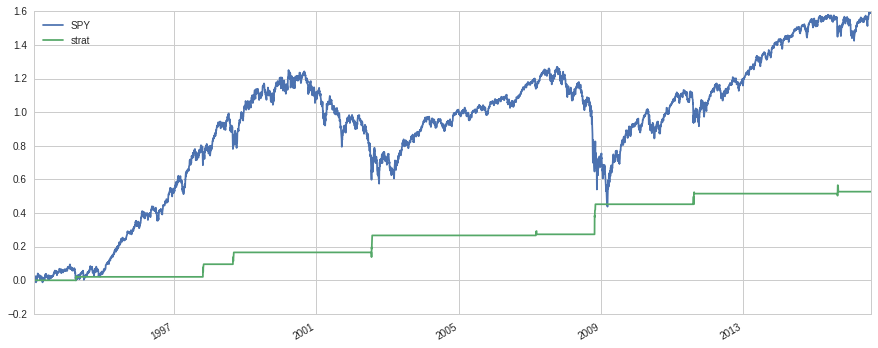

In [447]:
figsize(15, 6)
df = five_days_future["day0"].pct_change().to_frame()
df.columns = [ticker]
df['strat'] = df[ticker] * alloc.shift(1)
core.cumsum_log(df).plot()
core.quick_stats(df, "zero")

In [308]:
buying_dates

DatetimeIndex(['1994-04-04', '1997-10-27', '1998-08-31', '2002-07-22',
               '2007-03-05', '2008-10-27', '2011-08-08', '2015-08-24'],
              dtype='datetime64[ns]', freq=None)

In [344]:
five_days_future["day0"][alloc > 0.2].ix["1998"]

1998-08-31     96.00000
1998-09-01    100.06250
1998-09-02     99.34375
1998-09-03     98.56250
1998-09-04     97.75000
Name: day0, dtype: float64

In [345]:
df.ix["1998-08"]

,SPY,strat
1998-08-03,-0.004194,-0.000000
1998-08-04,-0.038742,-0.000000
1998-08-05,0.013727,0.000000
1998-08-06,0.004321,0.000000
1998-08-07,0.001721,0.000000
1998-08-10,-0.005727,-0.000000
1998-08-11,-0.014977,-0.000000
1998-08-12,0.016959,0.000000
1998-08-13,-0.012076,-0.000000
1998-08-14,-0.011641,-0.000000
